In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.cm import ScalarMappable

# Parameters
N = 40  # time steps
dt = 0.25  # quarterly
F = 1.0  # principal
c = 0.06  # annual coupon
r0 = 0.05  # initial short rate
sigma = 0.05  # constant volatility
C_val = 1.01  # call price
P_val = 0.99  # put price
phi_val = 1.00  # payoff when both exercise

# Lattice generation
def gen_rate_tree(N, r0, dt, sigma):
    tree = [[r0 * np.exp(2 * sigma * dt * (i - n/2)) for i in range(n + 1)] for n in range(N + 1)]
    return tree

# Zero-coupon bond discount factor at each node
def gen_discount_tree(rate_tree, dt):
    return [[np.exp(-r * dt) for r in row] for row in rate_tree]

# Backward induction for game option bond
def price_game_option_bond(N, F, c, C_val, P_val, phi_val, disc_tree, rate_tree):
    V = [[0 for _ in range(n+1)] for n in range(N+1)]
    coupon = c * dt

    # Terminal payoff
    for i in range(N+1):
        V[N][i] = F + coupon

    # Work backwards
    for n in reversed(range(N)):
        for i in range(n+1):
            # Continuation value
            cont = 0.5 * (V[n+1][i] + V[n+1][i+1]) * disc_tree[n][i] + coupon

            # Game payoff matrix
            payoff_matrix = np.array([
                [cont, P_val + coupon],
                [C_val + coupon, phi_val + coupon]
            ])

            # Saddle point in pure strategies
            if P_val + coupon <= cont < C_val + coupon:
                val = P_val + coupon
            elif cont <= P_val + coupon:
                val = cont
            elif C_val + coupon <= cont:
                val = C_val + coupon
            else:
                val = phi_val + coupon

            V[n][i] = val

    return V

# Run model
rate_tree = gen_rate_tree(N, r0, dt, sigma)
disc_tree = gen_discount_tree(rate_tree, dt)
V_tree = price_game_option_bond(N, F, c, C_val, P_val, phi_val, disc_tree, rate_tree)

# Define volatility range again since it was in earlier scope
vol_range = np.linspace(0.0, 0.5, 51)

# Display bond value at root
V_tree[0][0]

1.005

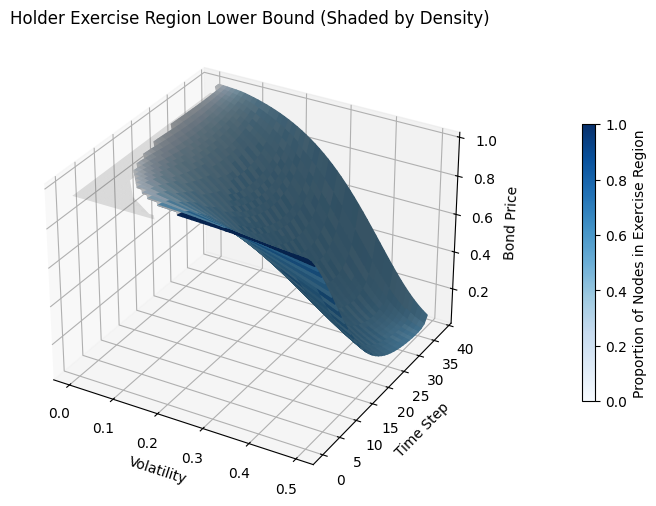

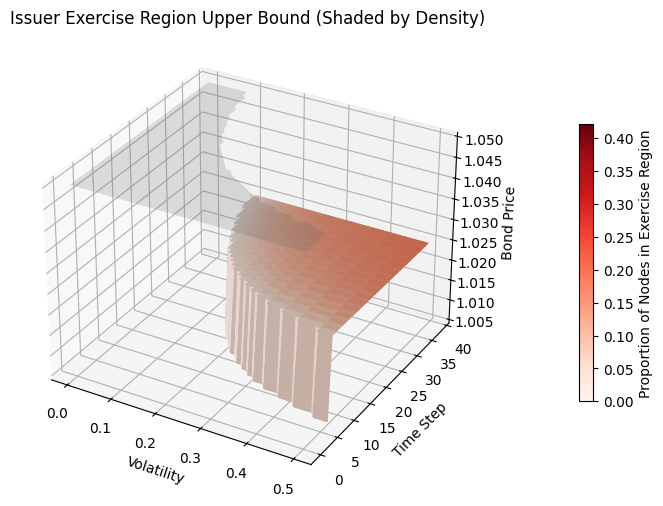

In [2]:
def get_exercise_bounds_and_density_fixed(N, F, c, C_val, P_val, phi_val, disc_tree, rate_tree, V_tree):
    coupon = c * dt
    holder_bounds = np.full(N - 1, np.nan)
    issuer_bounds = np.full(N - 1, np.nan)
    holder_density = np.zeros(N - 1)
    issuer_density = np.zeros(N - 1)

    for n in range(N - 1):  # Exclude final time step from exercise
        holder_triggered = []
        issuer_triggered = []
        total_nodes = n + 1
        holder_count = 0
        issuer_count = 0

        for i in range(n + 1):
            continuation = 0.5 * (V_tree[n + 1][i] + V_tree[n + 1][i + 1]) * disc_tree[n][i] + coupon
            if continuation <= P_val + coupon < C_val + coupon:
                holder_triggered.append(V_tree[n][i])
                holder_count += 1
            elif P_val + coupon < C_val + coupon <= continuation:
                issuer_triggered.append(V_tree[n][i])
                issuer_count += 1
            elif continuation >= phi_val + coupon:
                holder_triggered.append(V_tree[n][i])
                issuer_triggered.append(V_tree[n][i])
                holder_count += 1
                issuer_count += 1

        if holder_triggered:
            holder_bounds[n] = min(holder_triggered)
        if issuer_triggered:
            issuer_bounds[n] = max(issuer_triggered)

        holder_density[n] = holder_count / total_nodes
        issuer_density[n] = issuer_count / total_nodes

    return holder_bounds, issuer_bounds, holder_density, issuer_density


def plot_bond_price_planes_with_density_scale(vol_list, N, r0, dt, F, c, C_val, P_val, phi_val):
    time_steps = np.arange(N - 1)
    vol_mesh, time_mesh = np.meshgrid(vol_list, time_steps)

    holder_plane = np.zeros_like(vol_mesh)
    issuer_plane = np.zeros_like(vol_mesh)
    holder_alpha = np.zeros_like(vol_mesh)
    issuer_alpha = np.zeros_like(vol_mesh)

    holder_mask = np.zeros_like(vol_mesh, dtype=bool)
    issuer_mask = np.zeros_like(vol_mesh, dtype=bool)

    for j, sigma in enumerate(vol_list):
        rate_tree = gen_rate_tree(N, r0, dt, sigma)
        disc_tree = gen_discount_tree(rate_tree, dt)
        V_tree = price_game_option_bond(N, F, c, C_val, P_val, phi_val, disc_tree, rate_tree)
        holder_bounds, issuer_bounds, holder_density, issuer_density = get_exercise_bounds_and_density_fixed(
            N, F, c, C_val, P_val, phi_val, disc_tree, rate_tree, V_tree
        )

        holder_plane[:, j] = holder_bounds
        issuer_plane[:, j] = issuer_bounds
        holder_alpha[:, j] = holder_density
        issuer_alpha[:, j] = issuer_density

        holder_mask[:, j] = ~np.isnan(holder_bounds)
        issuer_mask[:, j] = ~np.isnan(issuer_bounds)

    # Plot holder exercise region
    fig1 = plt.figure(figsize=(13, 6))
    ax1 = fig1.add_subplot(111, projection='3d')
    holder_surf = ax1.plot_surface(vol_mesh, time_mesh, holder_plane, facecolors=cm.Blues(holder_alpha), rstride=1, cstride=1)
    holder_base = np.where(holder_mask, np.nan, 0.95)
    ax1.plot_surface(vol_mesh, time_mesh, holder_base, color='gray', alpha=0.2)
    ax1.set_title('Holder Exercise Region Lower Bound (Shaded by Density)')
    ax1.set_xlabel('Volatility')
    ax1.set_ylabel('Time Step')
    ax1.set_zlabel('Bond Price')
    mappable1 = ScalarMappable(cmap=cm.Blues)
    mappable1.set_array(holder_alpha)
    cbar1 = fig1.colorbar(mappable1, ax=ax1, shrink=0.6, pad=0.1)
    cbar1.set_label('Proportion of Nodes in Exercise Region')

    # Plot issuer exercise region
    fig2 = plt.figure(figsize=(13, 6))
    ax2 = fig2.add_subplot(111, projection='3d')
    issuer_surf = ax2.plot_surface(vol_mesh, time_mesh, issuer_plane, facecolors=cm.Reds(issuer_alpha), rstride=1, cstride=1)
    issuer_base = np.where(issuer_mask, np.nan, 1.05)
    ax2.plot_surface(vol_mesh, time_mesh, issuer_base, color='gray', alpha=0.2)
    ax2.set_title('Issuer Exercise Region Upper Bound (Shaded by Density)')
    ax2.set_xlabel('Volatility')
    ax2.set_ylabel('Time Step')
    ax2.set_zlabel('Bond Price')
    mappable2 = ScalarMappable(cmap=cm.Reds)
    mappable2.set_array(issuer_alpha)
    cbar2 = fig2.colorbar(mappable2, ax=ax2, shrink=0.6, pad=0.1)
    cbar2.set_label('Proportion of Nodes in Exercise Region')

    plt.show()

# Run with colorbars
plot_bond_price_planes_with_density_scale(vol_range, N, r0, dt, F, c, C_val, P_val, phi_val)

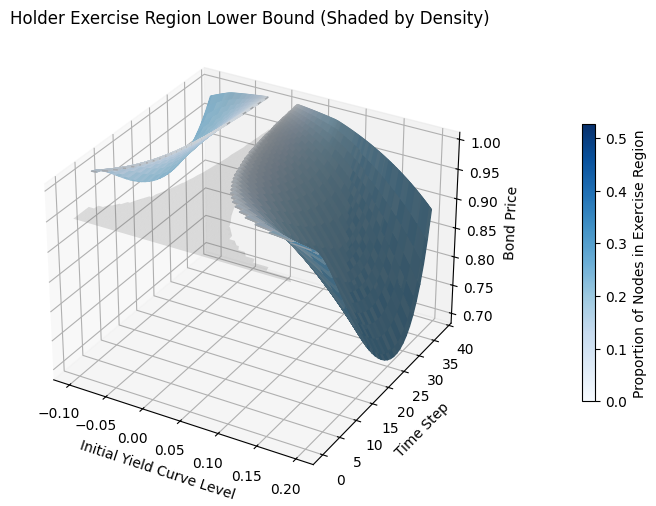

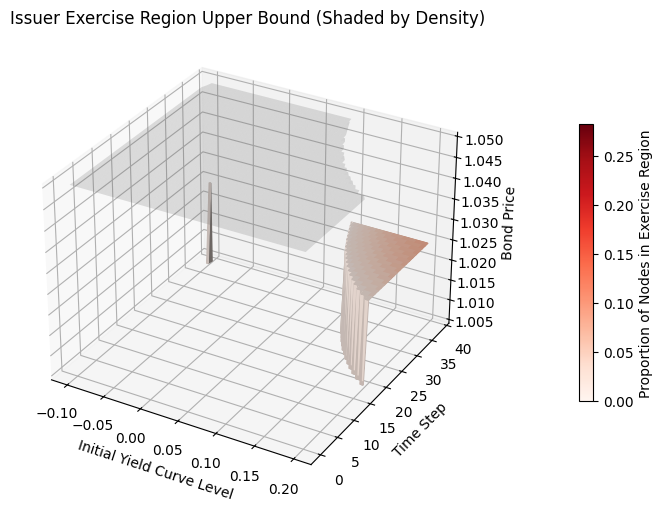

In [3]:
yield_levels = np.linspace(-0.1, 0.20, 301)  # 4% to 6% in 20bps steps
def yield_plot_bond_price_planes_with_density_scale(yield_levels, N, r0, dt, F, c, C_val, P_val, phi_val):
    time_steps = np.arange(N - 1)
    yield_mesh, time_mesh = np.meshgrid(yield_levels, time_steps)

    holder_plane = np.zeros_like(yield_mesh)
    issuer_plane = np.zeros_like(yield_mesh)
    holder_alpha = np.zeros_like(yield_mesh)
    issuer_alpha = np.zeros_like(yield_mesh)

    holder_mask = np.zeros_like(yield_mesh, dtype=bool)
    issuer_mask = np.zeros_like(yield_mesh, dtype=bool)

    for j, sigma in enumerate(yield_levels):
        rate_tree = gen_rate_tree(N, r0, dt, sigma)
        disc_tree = gen_discount_tree(rate_tree, dt)
        V_tree = price_game_option_bond(N, F, c, C_val, P_val, phi_val, disc_tree, rate_tree)
        holder_bounds, issuer_bounds, holder_density, issuer_density = get_exercise_bounds_and_density_fixed(
            N, F, c, C_val, P_val, phi_val, disc_tree, rate_tree, V_tree
        )

        holder_plane[:, j] = holder_bounds
        issuer_plane[:, j] = issuer_bounds
        holder_alpha[:, j] = holder_density
        issuer_alpha[:, j] = issuer_density

        holder_mask[:, j] = ~np.isnan(holder_bounds)
        issuer_mask[:, j] = ~np.isnan(issuer_bounds)

    # Plot holder exercise region
    fig1 = plt.figure(figsize=(13, 6))
    ax1 = fig1.add_subplot(111, projection='3d')
    holder_surf = ax1.plot_surface(yield_mesh, time_mesh, holder_plane, facecolors=cm.Blues(holder_alpha), rstride=1, cstride=1)
    holder_base = np.where(holder_mask, np.nan, 0.95)
    ax1.plot_surface(yield_mesh, time_mesh, holder_base, color='gray', alpha=0.2)
    ax1.set_title('Holder Exercise Region Lower Bound (Shaded by Density)')
    ax1.set_xlabel('Initial Yield Curve Level')
    ax1.set_ylabel('Time Step')
    ax1.set_zlabel('Bond Price')
    mappable1 = ScalarMappable(cmap=cm.Blues)
    mappable1.set_array(holder_alpha)
    cbar1 = fig1.colorbar(mappable1, ax=ax1, shrink=0.6, pad=0.1)
    cbar1.set_label('Proportion of Nodes in Exercise Region')

    # Plot issuer exercise region
    fig2 = plt.figure(figsize=(13, 6))
    ax2 = fig2.add_subplot(111, projection='3d')
    issuer_surf = ax2.plot_surface(yield_mesh, time_mesh, issuer_plane, facecolors=cm.Reds(issuer_alpha), rstride=1, cstride=1)
    issuer_base = np.where(issuer_mask, np.nan, 1.05)
    ax2.plot_surface(yield_mesh, time_mesh, issuer_base, color='gray', alpha=0.2)
    ax2.set_title('Issuer Exercise Region Upper Bound (Shaded by Density)')
    ax2.set_xlabel('Initial Yield Curve Level')
    ax2.set_ylabel('Time Step')
    ax2.set_zlabel('Bond Price')
    mappable2 = ScalarMappable(cmap=cm.Reds)
    mappable2.set_array(issuer_alpha)
    cbar2 = fig2.colorbar(mappable2, ax=ax2, shrink=0.6, pad=0.1)
    cbar2.set_label('Proportion of Nodes in Exercise Region')

    plt.show()

# Run with colorbars
yield_plot_bond_price_planes_with_density_scale(yield_levels, N, r0, dt, F, c, C_val, P_val, phi_val)


In [4]:
def get_exercise_bounds_and_density(N, F, c, C_val, P_val, phi_val, disc_tree, rate_tree, V_tree):
    coupon = c * dt
    holder_bounds = np.full(N, np.nan)
    issuer_bounds = np.full(N, np.nan)
    holder_density = np.zeros(N)
    issuer_density = np.zeros(N)

    for n in range(N-1):
        holder_triggered = []
        issuer_triggered = []
        total_nodes = n + 1
        holder_count = 0
        issuer_count = 0

        for i in range(n + 1):
            continuation = 0.5 * (V_tree[n + 1][i] + V_tree[n + 1][i + 1]) * disc_tree[n][i] + coupon
            if continuation <= P_val + coupon < C_val + coupon:
                holder_triggered.append(V_tree[n][i])
                holder_count += 1
            elif P_val + coupon < C_val + coupon <= continuation:
                issuer_triggered.append(V_tree[n][i])
                issuer_count += 1
            elif continuation >= phi_val + coupon:
                holder_triggered.append(V_tree[n][i])
                issuer_triggered.append(V_tree[n][i])
                holder_count += 1
                issuer_count += 1

        if holder_triggered:
            holder_bounds[n] = min(holder_triggered)
        if issuer_triggered:
            issuer_bounds[n] = max(issuer_triggered)

        holder_density[n] = holder_count / total_nodes
        issuer_density[n] = issuer_count / total_nodes

    return holder_bounds, issuer_bounds, holder_density, issuer_density


In [5]:
V_tree

[[1.005],
 [1.005, 1.005],
 [1.005, 1.005, 1.005],
 [1.005, 1.005, 1.005, 1.005],
 [1.005, 1.005, 1.005, 1.005, 1.005],
 [1.005, 1.005, 1.005, 1.005, 1.005, 1.005],
 [1.005, 1.005, 1.005, 1.005, 1.005, 1.005, 1.005],
 [1.005, 1.005, 1.005, 1.005, 1.005, 1.005, 1.005, 1.005],
 [1.005, 1.005, 1.005, 1.005, 1.005, 1.005, 1.005, 1.005, 1.005],
 [1.005, 1.005, 1.005, 1.005, 1.005, 1.005, 1.005, 1.005, 1.005, 1.005],
 [1.005, 1.005, 1.005, 1.005, 1.005, 1.005, 1.005, 1.005, 1.005, 1.005, 1.005],
 [1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005],
 [1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005],
 [1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  np.float64(1.004192376231197)],
 [1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
  1.005,
 

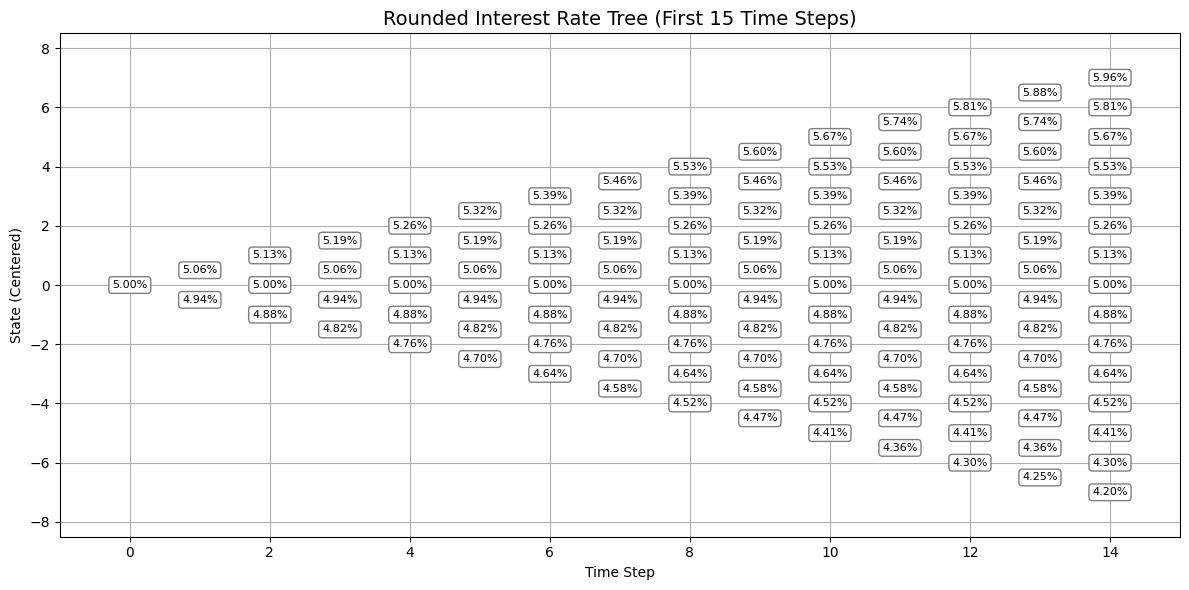

In [9]:
def plot_rounded_rate_tree(rate_tree, max_nodes=15):
    """
    Plot the binomial interest rate tree with rounded rates.
    Limits time steps shown to `max_nodes` for clarity.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    for n, row in enumerate(rate_tree[:max_nodes]):
        for i, r in enumerate(row):
            x = n
            y = i - n / 2
            rounded_rate = round(r * 100, 2)  # in percentage
            ax.text(x, y, f"{rounded_rate:.2f}%", ha='center', va='center', fontsize=8,
                    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

    ax.set_title(f"Rounded Interest Rate Tree (First {max_nodes} Time Steps)", fontsize=14)
    ax.set_xlabel("Time Step")
    ax.set_ylabel("State (Centered)")
    ax.set_xlim(-1, max_nodes)
    ax.set_ylim(-max_nodes/2 - 1, max_nodes/2 + 1)
    ax.grid(True)
    plt.tight_layout()
    plt.show()
rounded_rate_tree = gen_rate_tree(N, r0, dt, sigma)
plot_rounded_rate_tree(rounded_rate_tree, max_nodes=15)  # Adjust max_nodes for density
